In [1]:
import sys
import math
import matplotlib.pyplot as plt
import cv2
sys.path.append('../')

from scripts.point_cloud_utils import send_point_cloud
from pyngp.common import *
from tqdm import tqdm
import pyngp.pyngp as ngp
from  scripts.ros_utils import get_image_tf_pair, send_tf



In [2]:
width = 854
height = 480
spp = 1 # 1 is fast 8 is default

objects = ['table', 'truck', 'block']
testbed_map = {}
for obj in objects:
    testbed = ngp.Testbed()
    testbed.load_snapshot(f'../nerf/{obj}.ingp')
    testbed_map[obj] = testbed
def srgb_to_linear(img):
    limit = 0.04045
    return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

def linear_to_srgb(img):
    limit = 0.0031308
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

camera_matrix = testbed_map['table'].camera_matrix


13:40:41 SUCCESS  Initialized CUDA 12.0. Active GPU is #0: NVIDIA GeForce RTX 4090 [89]
13:40:41 INFO     Loading network snapshot from: ../nerf/table.ingp
13:40:44 DEBUG    GPUMemory: allocating 1.41 KB.
13:40:44 DEBUG    GPUMemory: allocating 144 B.
13:40:44 DEBUG    GPUMemory: allocating 144 B.
13:40:44 DEBUG    GPUMemory: allocating 144 B.
13:40:44 DEBUG    GPUMemory: allocating 144 B.
13:40:44 DEBUG    GPUMemory: allocating 8 B.
13:40:44 DEBUG    GPUMemory: allocating 1.12 KB.
13:40:44 DEBUG    GPUMemory: allocating 4 MB.
13:40:44 DEBUG    GPUMemory: allocating 8 MB.
13:40:44 DEBUG    GPUMemory: allocating 2 MB.
13:40:44 DEBUG    GPUMemory: allocating 64 KB.
13:40:44 INFO     GridEncoding:  Nmin=16 b=2 F=4 T=2^22 L=8
13:40:44 DEBUG    GridEncoding at level 0: resolution=16 params_in_level=4096
13:40:44 DEBUG    GridEncoding at level 1: resolution=32 params_in_level=32768
13:40:44 DEBUG    GridEncoding at level 2: resolution=64 params_in_level=262144
13:40:44 DEBUG    GridEncoding 

In [3]:
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
tf = tf[0]
ros_image = ros_image[0]

c2w = tf.copy()
c2w[0:3, 2] *= -1  # flip the y and z axis
c2w[0:3, 1] *= -1
c2w = c2w[[1, 0, 2, 3], :]
c2w[2, :] *= -1  # flip whole world upside down
tf_ngp = c2w
tf_ngp = tf_ngp[:-1, :]

testbed.set_nerf_camera_matrix(tf_ngp)
camera_matrix2 = testbed.camera_matrix.copy()

depth_buffer = 10000000*np.ones((height, width))
image_composed = np.zeros((height, width, 3))



for obj in objects:
    testbed = testbed_map[obj]
    camera_matrix_tmp = camera_matrix2.copy()
    if obj != 'table':
        tmp = (.2*(np.random.rand(3, 1)-.5) ).squeeze()
        tmp[2] = 0
        camera_matrix_tmp[:, -1] = camera_matrix_tmp[:, -1] + camera_matrix_tmp[:, :3] @ tmp
    testbed.camera_matrix = camera_matrix_tmp
    testbed.nerf.render_min_transmittance = 0.01
    testbed.render_mode = ngp.RenderMode.Shade
    testbed.color_space = ngp.ColorSpace.Linear
    image = testbed.render(width, height, spp, True)
    testbed.nerf.render_min_transmittance = 0.9
    testbed.render_mode = ngp.RenderMode.Depth
    depth = testbed.render(width, height, spp, True)
    depth = depth[:,:,0]
    inds = (depth < depth_buffer) * (depth > 0.2)
    image_composed[inds, 0] = image[inds, 0]
    image_composed[inds, 1] = image[inds, 1]
    image_composed[inds, 2] = image[inds, 2]
    depth_buffer[inds] = depth[inds]

image_composed = linear_to_srgb(image_composed)


13:40:51 DEBUG    GPUMemory: allocating 6.25 MB.
13:40:51 DEBUG    GPUMemory: allocating 1.56 MB.
13:40:51 DEBUG    GPUMemory: allocating 6.25 MB.
13:40:51 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
13:40:51 DEBUG    GPUMemoryArena: enlarging from 260 MB to 383 MB
13:40:51 DEBUG    GPUMemoryArena: enlarging from 384 MB to 508 MB
13:40:51 DEBUG    GPUMemory: allocating 6.25 MB.
13:40:51 DEBUG    GPUMemory: allocating 1.56 MB.
13:40:51 DEBUG    GPUMemory: allocating 6.25 MB.
13:40:51 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
13:40:51 DEBUG    GPUMemoryArena: enlarging from 260 MB to 275 MB
13:40:51 DEBUG    GPUMemoryArena: enlarging from 276 MB to 291 MB
13:40:51 DEBUG    GPUMemory: allocating 6.25 MB.
13:40:51 DEBUG    GPUMemory: allocating 1.56 MB.
13:40:51 DEBUG    GPUMemory: allocating 6.25 MB.
13:40:51 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB


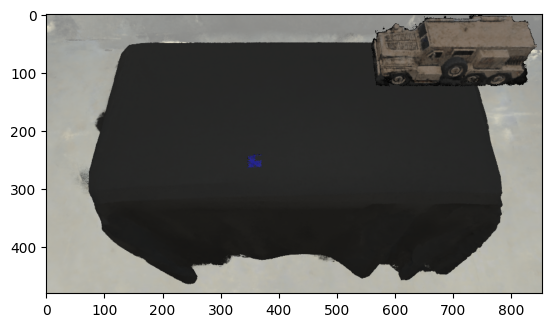

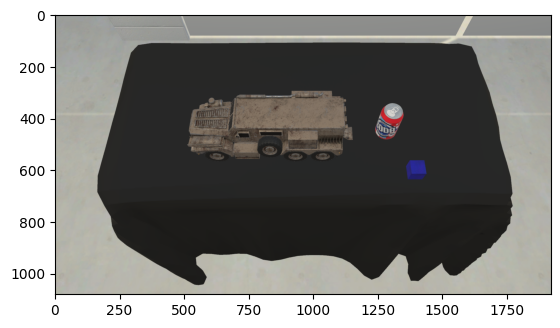

In [4]:
plt.figure()
plt.imshow(image_composed)
plt.figure()
plt.imshow(ros_image)

scale = 1.0
image_composed = cv2.resize(image_composed, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
ros_image = cv2.resize(ros_image, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC) 
tmp = np.max(depth_buffer)
depth_buffer = tmp*cv2.resize(depth_buffer/tmp, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR) 

In [5]:
sys.path.append('../unimatch_repo')

import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from evaluate_flow import inference_flow
from utils.flow_viz import flow_to_image
from PIL import Image as im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='flow').to(device)

trained_model_path = '../unimatch_repo/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_model_path, map_location=loc)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

In [6]:
import sys
sys.path.append('../unimatch_repo')
import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from dataloader.stereo import transforms
from utils.visualization import viz_depth_tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stereo = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='stereo').to(device)

trained_depth_path = '../unimatch_repo/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_depth_path, map_location=loc)
model_stereo.load_state_dict(checkpoint['model'], strict=False)
model_stereo.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

1.795710563659668


/home/paul/CLionProjects/thesis_nerf/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


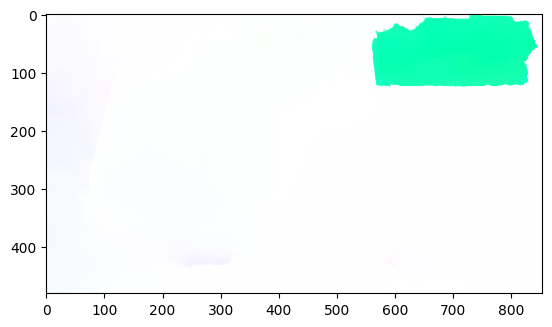

In [7]:

def get_flow(model, image1, image2): 
    padding_factor=32

    # the model is trained with size: width > height
    transpose_img = False
    if image1.size(-2) > image1.size(-1):
        image1 = torch.transpose(image1, -2, -1)
        image2 = torch.transpose(image2, -2, -1)
        transpose_img = True

    nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]
    fixed_inference_size = None
    # fixed_inference_size = [val//2 for val in nearest_size] 
#     fixed_inference_size = (224, 384)

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
    ori_size = image1.shape[-2:]

    # resize before inference
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                               align_corners=True)
        image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                               align_corners=True)


    for i in range(1):
        import time
        start = time.time()
        with torch.inference_mode():
            results_dict = model(image1, image2,
                                attn_type='swin',
                                attn_splits_list=[2, 8],
                                corr_radius_list=[-1, 4],
                                prop_radius_list=[-1, 1],
                                num_reg_refine=6,
                                task='flow'
                                )
        print(time.time() - start)


    flow_pr = results_dict['flow_preds'][-1]

    # resize back
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        flow_pr = F.interpolate(flow_pr, size=ori_size, mode='nearest') # align_corners=True
        flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
        flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

    if transpose_img:
        flow_pr = torch.transpose(flow_pr, -2, -1)

    flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]
    return flow 


image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)
    
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def get_points(depth, tf_cam_world_inv, fov, width, height):
    fx = 2*np.tan(fov/2.0)
    fy = fx*width/height
    Z = depth
    [Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, width), np.linspace(-.5, .5, height))
    X = (Xgrid)*Z/fx
    Y = (Ygrid)*Z/fy
    points = np.stack([X, Y, Z], axis=2);
    points = np.reshape(points, (-1, 3))
    points = (points @ tf_cam_world_inv[:3, :3].transpose()) + np.reshape(tf_cam_world_inv[:3, 3], (1, 3))
    
    return points

cached_render = {}
def render_nerf(testbed_map, tf_map, fov, width, height):
    all_points = []
    all_depth = []
    depth_buffer = 10000000*np.ones((height, width))
    image_composed = np.zeros((height, width, 3))
    object_inds = np.zeros((height, width), dtype=np.int32)
    
    
    for ind, obj in enumerate(testbed_map):
        testbed = testbed_map[obj]
        tf_nerf_cam = tf_map[obj]
        tf_cam_nerf = np.linalg.inv(tf_nerf_cam.detach().cpu().numpy())
        c2w = tf_cam_nerf.copy()
        c2w[0:3, 2] *= -1  # flip the y and z axis
        c2w[0:3, 1] *= -1
        c2w = c2w[[1, 0, 2, 3], :]
        c2w[2, :] *= -1  # flip whole world upside down
        tf_ngp = c2w
        tf_ngp = tf_ngp[:-1, :]
        testbed.set_nerf_camera_matrix(tf_ngp)

        if obj == 'table' and obj in cached_render:
            image, depth = cached_render[obj]
        else:
            testbed.nerf.render_min_transmittance = 0.01
            testbed.render_mode = ngp.RenderMode.Shade
            testbed.color_space = ngp.ColorSpace.Linear
            image = testbed.render(width, height, spp, True)
            testbed.nerf.render_min_transmittance = 0.9
            testbed.render_mode = ngp.RenderMode.Depth
            depth = testbed.render(width, height, spp, True)
        
        if obj == 'table' and obj not in cached_render:
            cached_render[obj] = (image, depth)
            
        depth = depth[:, :, 0]
        depth[depth < 0.1]  = 10000000
        inds = (depth < depth_buffer)
        image_composed[inds, 0] = image[inds, 0]
        image_composed[inds, 1] = image[inds, 1]
        image_composed[inds, 2] = image[inds, 2]
        depth_buffer[inds] = depth[inds]
        object_inds[inds] = ind
        
        all_depth.append(depth.flatten())
        points = get_points(depth, tf_cam_nerf, fov, width, height) 
        Rt_tensor = tf_nerf_cam[:3, :3].transpose(0, 1)
        p_tensor = tf_nerf_cam[:3, 3]
        points = torch.tensor(points, dtype=torch.float32, device='cuda', requires_grad=False)
        points_tensor = (points @ Rt_tensor) + torch.reshape(p_tensor, (1, 3)) # need grad
        all_points.append(points_tensor)
        
        
    all_points = torch.stack(all_points, axis=0)
    all_depth = torch.tensor(np.vstack(all_depth), dtype=torch.float32, device='cuda')
    min_z, inds = torch.min(all_depth, axis=0) # keepdim=True 
    
    x_vals = all_points[:, :, 0].flatten()
    y_vals = all_points[:, :, 1].flatten()
    z_vals = all_points[:, :, 2].flatten()
    
    inds = inds*inds.shape[0] + torch.linspace(0, inds.shape[0]-1, inds.shape[0], dtype=torch.int32, device='cuda')
    
    points_composed = torch.stack([x_vals[inds], y_vals[inds], z_vals[inds]], axis=1)
    image_composed = linear_to_srgb(image_composed)
    
    return points_composed, image_composed, object_inds  



def get_transform(rpy_params, xyz_params):
    rpy_params = torch.reshape(rpy_params, (3,1))
    xyz_params = torch.reshape(xyz_params, (3,1)) 
    ct = torch.cos(rpy_params);
    st = torch.sin(rpy_params);
    R00 = ct[0]*ct[2]*ct[1] - st[0]*st[2]
    R01 = -ct[0]*ct[1]*st[2] - st[0]*ct[2]
    R02 = ct[0]*st[1]
    R10 = st[0]*ct[2]*ct[1] + ct[0]*st[2]
    R11 = -st[0]*ct[1]*st[2] + ct[0]*ct[2]
    R12 = st[0]*st[1]
    R20 = -st[1]*ct[2]
    R21 = st[1]*st[2]
    R22 = ct[1]
    R0 = torch.hstack([R00, R01, R02])
    R1 = torch.hstack([R10, R11, R12])
    R2 = torch.hstack([R20, R21, R22])
    R = torch.stack([R0, R1, R2], axis=0);
        
    row = torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=torch.float32, device='cuda')
    M = torch.hstack([R, xyz_params])
    T = torch.vstack([M, row])
    return T

class CorrespondenceNet(nn.Module):
    def __init__(self, testbed_map, width, height, tf):
        super(CorrespondenceNet, self).__init__()
        self.testbed_map = testbed_map
        self.width = width
        self.height = height
        self.objects = [key for key in testbed_map.keys() ]
#         tmp = 2*3.14*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[0::3] = 0
#         tmp[1::3] = 0
#         self.rpy = nn.Parameter(tmp)
#         tmp = .25 - .5*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[2::3] = 0
#         self.xyz = nn.Parameter(tmp)
        self.fov = testbed_map['table'].fov
        assert all([testbed_map[key].fov == self.fov for key in testbed_map])
        self.fov = math.pi*self.fov/180.0
        self.tf_cam_world = torch.tensor(tf, dtype=torch.float32, device='cuda') 
        self.default_transforms = {}
        self.tf_nerf_cam = {}
        
        
        for obj in self.objects:
            T = np.linalg.inv(tf)
            self.default_transforms[obj] = torch.tensor(T, dtype=torch.float32, device='cuda')
        for obj in self.objects:
            self.reset_transform(obj)
        
        
    def reset_transform(self, obj):
        if obj == 'table':
            self.tf_nerf_cam[obj] = self.default_transforms[obj]
            return
                
        box_tf = np.eye(4,4, dtype=np.float32)
        box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
        box_tf[[0,1], 3] = box_tf[[1,0], 3]
        xyz = .25 - .5*torch.rand(3, dtype=torch.float32, device='cuda')
        xyz[2::3] = 0
        tf_trans_learned = get_transform(torch.zeros(3).to(device), xyz)
        rpy = 2*3.14*torch.rand(3, dtype=torch.float32, device='cuda')
        rpy[0::3] = 0
        rpy[1::3] = 0
        tf_rot_learned = get_transform(rpy, torch.zeros(3).to(device))
        box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
        box_tf = torch.from_numpy(box_tf).to(device)

        default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
                                        [ 0.0000,  1.0, 0, 0],
                                        [-0.0000, 0, -1.0,  0],
                                        [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
        default_transform[0,3] += box_tf[0,3]
        default_transform[1,3] += box_tf[1,3]
        default_transform[2,3] += box_tf[2,3] + 0.8
        default_transform = torch.linalg.inv(default_transform)

        tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
        tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
        self.tf_nerf_cam[obj] = tf_nerf_cam 
                
        
    def forward(self):
        tf_map = {}
        ind = 0
        for obj in self.objects:
#             default_transform = self.default_transforms[obj]
#             if obj != 'table':
#                 box_tf = np.eye(4,4, dtype=np.float32)
#                 box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
#                 box_tf[[0,1], 3] = box_tf[[1,0], 3]
                
#                 tf_trans_learned = get_transform(torch.zeros(3).to(device), self.xyz[(ind)*3:(ind+1)*3])
#                 tf_rot_learned = get_transform(self.rpy[(ind)*3:(ind+1)*3], torch.zeros(3).to(device))
#                 box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
#                 box_tf = torch.from_numpy(box_tf).to(device)
                
#                 default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
#                                                 [ 0.0000,  1.0, 0, 0],
#                                                 [-0.0000, 0, -1.0,  0],
#                                                 [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
#                 default_transform[0,3] += box_tf[0,3]
#                 default_transform[1,3] += box_tf[1,3]
#                 default_transform[2,3] += box_tf[2,3] + 0.8
#                 default_transform = torch.linalg.inv(default_transform)

#                 tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
#                 tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
                
#                 ind += 1
#             else:
#                 tf_nerf_cam = default_transform
            tf_map[obj] = self.tf_nerf_cam[obj]
            
        points_composed, image_composed, object_inds = render_nerf(self.testbed_map, tf_map, self.fov, self.width, self.height)
        
        Rt = self.tf_cam_world[:3, :3].transpose(0,1)
        points_composed_world = (points_composed @ Rt) + torch.reshape(self.tf_cam_world[:3, 3], (1, 3)) 
        x = points_composed[:, 0]/points_composed[:, 2];
        y = points_composed[:, 1]/points_composed[:, 2];
        points_2d = torch.stack([x, y], axis=1)
        
        return points_composed, points_composed_world, points_2d, image_composed, object_inds

def compute_loss(pred_points, target_points, uv, target_grid):
    loss = F.huber_loss(pred_points, target_points)
    return loss
    
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
ros_image = ros_image[0]
tf = tf[0]
network = CorrespondenceNet(testbed_map, width, height, tf)
network.cuda(device='cuda')



[WARN] [1695750054.762835199] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


CorrespondenceNet()

13:40:55 DEBUG    GPUMemoryArena: enlarging from 292 MB to 295 MB


[WARN] [1695750055.387910728] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


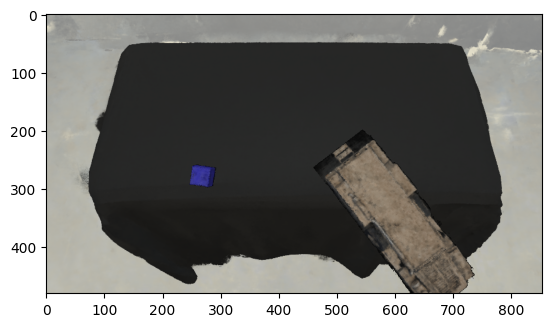

In [9]:
points_composed, points_composed_world, points_2d, image_composed, object_inds = network()
plt.figure()
plt.imshow(image_composed)
colors = np.reshape(image_composed, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)

# tmp = np.ones(points_composed_world.shape)
# tmp[:, :2] = points_2d.detach().cpu().numpy()
# send_point_cloud(np.hstack((tmp, colors)), has_alpha=False, topic='point_cloud_2')
# print(torch.max(points_2d))

0.11416220664978027


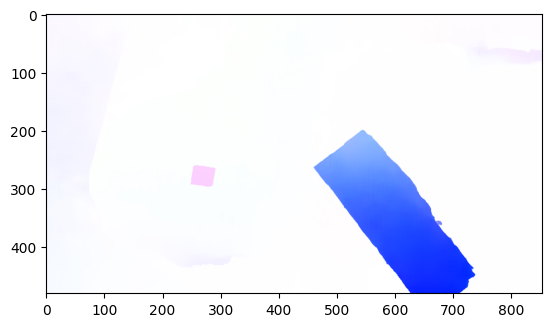

In [10]:
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

[WARN] [1695750057.466223599] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]


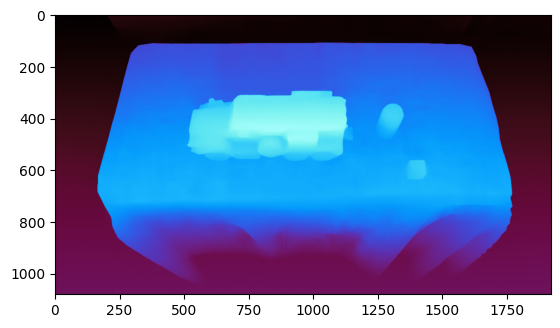

In [11]:
from utils.visualization import vis_disparity

def get_disparity(model_stereo, left, right):
    padding_factor = 32
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]


    sample = {'left': left,
              'right': right
              }
    val_transform_list = [transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
    val_transform = transforms.Compose(val_transform_list)
    sample = val_transform(sample)
    left = sample['left'].to(device).unsqueeze(0)  # [1, 3, H, W]
    right = sample['right'].to(device).unsqueeze(0)  # [1, 3, H, W]

    nearest_size = [int(np.ceil(left.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(left.size(-1) / padding_factor)) * padding_factor]

    fixed_inference_size = [val//2 for val in nearest_size] 
    print(fixed_inference_size)
#     fixed_inference_size = [288, 480]
#     fixed_inference_size = None

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    ori_size = left.shape[-2:]

    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        left = F.interpolate(left, size=inference_size,
                             mode='bilinear',
                             align_corners=True)
        right = F.interpolate(right, size=inference_size,
                              mode='bilinear',
                                  align_corners=True)

    with torch.no_grad():
        import time
        for i  in range(1):
            start = time.time()
            pred_disp = model_stereo(left, right,
                               attn_type='self_swin2d_cross_swin1d',
                               attn_splits_list=[2, 8],
                               prop_radius_list=[-1, 1],
                               corr_radius_list=[-1, 4],
                               num_reg_refine=3,
                               task='stereo',
                               )['flow_preds'][-1]  # [1, H, W]
#             print(time.time() - start)



    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        pred_disp = F.interpolate(pred_disp.unsqueeze(1), size=ori_size, mode='nearest').squeeze(1)  # [1, H, W]


    disp = pred_disp[0].cpu().numpy()
    return disp 



left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
left_pose = left_pose[0]
left = left[0]

right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
right_pose = right_pose[0]
right = right[0]



left = left[:,:,:3].astype(np.float32)
left_ori = left.copy() 
right = right[:,:,:3].astype(np.float32)

disp = get_disparity(model_stereo, left, right)

plt.figure()
plt.imshow(vis_disparity(disp))


In [12]:
def get_points_from_disparity(disp, left_pose, right_pose):
    baseline = np.sqrt(np.sum((left_pose[:3,3]-right_pose[:3,3])**2))
    fov = 69.4*(math.pi/180.0)
    focal = 2*np.tan(fov/2.0)
    depth = baseline * focal / disp
    depth = depth/2.0 # correct for scaling

    points = 1000*get_points(depth, np.eye(4), math.pi*(42.5/180.0), depth.shape[1], depth.shape[0])
    Rt = left_pose[:3, :3].transpose(0,1)
    points = (points @ Rt) + np.reshape(left_pose[:3, 3], (1, 3)) 
    return points 

stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
tmp = left_ori/255
tmp[tmp>1.0] = 1.0

stereo_colors = np.reshape(tmp, (-1, 3))
stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])
send_point_cloud(np.hstack((stereo_points, stereo_colors)), has_alpha=False)




In [ ]:
from torch.nn.functional import grid_sample 
import cvxpy as cp
from qpsolvers import solve_qp
import time

def send_obj_tf(obj):
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)

def update_tf(obj, T):
    T_tensor = torch.from_numpy(T).to(device)
    T_new = torch.inverse(network.tf_cam_world) @ T_tensor @ network.tf_cam_world @ network.tf_nerf_cam[obj]
    network.tf_nerf_cam[obj] = T_new 

def calc_transform(object_points, target_object_points):
    A = object_points
    B = target_object_points

    centriodA = np.reshape(np.mean(A, axis=1), (3,1))
    centriodB = np.reshape(np.mean(B, axis=1), (3,1))

    H = (A-centriodA)@(B-centriodB).transpose()
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[2,:] *= -1
        R = Vt.T @ U.T
        assert np.linalg.det(R) > 0
    
    P = centriodB - R@centriodA
    
    return R, P

    
    
while True:
    # def find_matches():

    left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
    left_pose = left_pose[0]
    left = left[0]
    image2 = left[:,:,:3]
    image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)
    left = left[:,:,:3].astype(np.float32)
    stereo_colors = np.reshape(left/255, (-1, 3))
    stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])

    right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
    right_pose = right_pose[0]
    right = right[0]
    right = right[:,:,:3].astype(np.float32)
    start = time.time()
    disp = get_disparity(model_stereo, left, right)
    stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
    print(time.time()-start)
    
    grid_points = np.reshape(stereo_points, (disp.shape[0], disp.shape[1], 3))
    grid_points = torch.from_numpy(grid_points)

    find_objects = {'block':2, 'truck':1}
    object_points_map = {}    
    
    for it2 in range(1):     
        points_composed, points_composed_world, points_2d, image_composed, object_inds = network()    

        image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
        image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
        flow = get_flow(model, image1, image2)
        grid_flow = np.reshape(flow, (image_composed.shape[0], image_composed.shape[1], 2))
        grid_flow[:,:,0] = 2*grid_flow[:,:,0]/image_composed.shape[1]
        grid_flow[:,:,1] = 2*grid_flow[:,:,1]/image_composed.shape[0]
        grid_flow_mag = np.sqrt(np.sum(grid_flow**2, axis=2))

        [Xgrid, Ygrid] = np.meshgrid(np.linspace(-1.0, 1.0, image_composed.shape[1]), np.linspace(-1.0, 1.0, image_composed.shape[0]))
        grid_base  = np.stack([Xgrid, Ygrid], axis=2);
        grid_input = grid_base + grid_flow 
        grid_input = torch.from_numpy(grid_input)


        target_points = grid_sample(grid_points.transpose(0, 2).transpose(1, 2).unsqueeze(axis=0), grid_input.unsqueeze(axis=0), mode='nearest', padding_mode='border') # align_corners=None
        target_points = torch.reshape(target_points,(3, -1))
        target_points = target_points.transpose(0,1)
        target_points = target_points.to(device)


        objs = [v for v in find_objects.keys()]
        for obj in objs:
            obj_ind = find_objects[obj]
            object_points = points_composed_world[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            target_object_points = target_points[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            R = np.eye(3, 3, dtype=np.float32)
            P = np.zeros((3, 1), dtype=np.float32)
            T = np.eye(4,4, dtype=np.float32)
            num_points = 10

#             num_hits = 0
#             best_quality = 999999999999999999.0
            for attempt in range(20):
                if object_points.shape[0] < num_points:
                    break
#                 if num_hits >= 5:
#                     break
        
                inds = np.random.choice(object_points.shape[0], num_points, replace=False)
                
                R, P = calc_transform(object_points[inds, :].transpose(), target_object_points[inds, :].transpose())
            
                matched_points = (object_points @ R.transpose()) + np.reshape(P, (1, 3)) 
                quality = np.sqrt( np.sum( (matched_points-target_object_points)**2,axis=1) )
                quality_inds = np.argsort(quality)
                quality_inds = quality_inds[:(len(quality_inds)*5)//10]
                quality = quality[quality_inds]
                quality = np.max(quality)

                if quality > 0.02: # 0.025 is ideal
                    continue
                else:
                    sub_inds = np.linspace(0, len(quality_inds)-1, 100, dtype=np.int32)
                    quality_inds = quality_inds[sub_inds]
                
                    R, P = calc_transform(object_points[quality_inds, :].transpose(), target_object_points[quality_inds, :].transpose())
            
#                     num_hits += 1
                    print(quality)
#                     if quality < best_quality:
#                         best_quality = quality
                    print(f'found match: {obj}!')
                    object_points_map[obj] = object_points
                    T[:3, :3] = R
                    T[:3, 3] = P.flatten()
                    update_tf(obj, T)
                    find_objects.pop(obj)
                    break
                
        for obj in ['truck', 'block']:
            send_obj_tf(obj)
                    
        for obj in find_objects:
            network.reset_transform(obj)
        if len(find_objects)==0:
            break
        print(f'iter: {it2}')

    if len(find_objects)==0:
        pass
#         colors = np.reshape(image_composed, (-1, 3))
#         colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
#         colors = colors[np.reshape(object_inds == 1, (-1,)), :]
#         colors[:,:3] = colors[:,:3]*.2
#         colors[:, 1] = 1
#         matched_points = (object_points_map['truck'] @ R.transpose()) + np.reshape(P, (1, 3)) 
#         vals = np.hstack((matched_points, colors))
#         send_point_cloud(vals, has_alpha=False, topic='point_cloud_2')

        points_composed, points_composed_world, points_2d, image_composed, object_inds = network()    
        colors = np.reshape(image_composed, (-1, 3))
        colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
        send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)


# import cProfile
# cProfile.run("find_matches()")

print(quality)
print(attempt)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)



[WARN] [1695750062.600628303] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3497433662414551
0.1264197826385498
0.01216860418970962
found match: block!
iter: 0


/home/paul/CLionProjects/thesis_nerf/venv/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
[WARN] [1695750063.395332472] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750063.710337564] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with tha

[544, 960]
0.2377912998199463
13:41:04 DEBUG    GPUMemoryArena: enlarging from 296 MB to 296 MB
0.14863300323486328
0.013644637377213192
found match: block!
iter: 0


[WARN] [1695750064.477269264] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750064.600873019] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2237710952758789
0.12486529350280762
0.012984968491106435
found match: block!
iter: 0


[WARN] [1695750065.379890213] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750065.560250382] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3221547603607178
0.12134599685668945
0.00867910108127768
found match: block!
iter: 0


[WARN] [1695750066.369179553] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750066.733916673] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17461037635803223
0.12194395065307617
0.013430036131682319
found match: block!
iter: 0


[WARN] [1695750067.578083872] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18330717086791992
0.11289525032043457
0.008690048378712324
found match: block!
iter: 0


[WARN] [1695750068.179162085] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750068.376941850] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.23871231079101562
0.13372349739074707
0.005212982688836569
found match: block!
iter: 0


[WARN] [1695750069.171455369] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750069.386347965] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3255469799041748
0.11485433578491211
0.005007824487588664
found match: block!
0.01745624333828493
found match: truck!


[WARN] [1695750072.565821532] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3821263313293457
0.1279749870300293
0.0058746086883746974
found match: block!
0.015827220980438268
found match: truck!


[WARN] [1695750073.313135133] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750075.243612177] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3027157783508301
0.1151285171508789
0.006810298759227048
found match: block!
0.00934340032738892
found match: truck!


[WARN] [1695750076.197014870] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.32422876358032227
0.19191718101501465
0.006393304184332299
found match: block!
0.010228723329991068
found match: truck!


[WARN] [1695750080.350252448] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750082.337764634] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31484556198120117
0.11872625350952148
0.004669754651450165
found match: block!
0.013309499148769456
found match: truck!


[WARN] [1695750083.470214354] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750085.512773669] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3216838836669922
0.1313011646270752
0.01324697098609957
found match: block!
0.019419342493684592
found match: truck!


[WARN] [1695750088.190413912] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20462608337402344
0.11240243911743164
0.009143000854121562
found match: block!
0.00973093381608131
found match: truck!


[WARN] [1695750088.993420312] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750091.018471317] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2947077751159668
0.11116719245910645
0.00590027923317083
found match: block!
0.009483139813940047
found match: truck!


[WARN] [1695750091.815253007] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750093.966972702] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3234214782714844
0.10984230041503906
0.004694449587985302
found match: block!
0.010293632986666707
found match: truck!


[WARN] [1695750097.355860819] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.25650525093078613
0.11362600326538086
0.011673211128884099
found match: block!
0.009164137706689423
found match: truck!


[WARN] [1695750098.148859293] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750100.926125899] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3209116458892822
0.12252044677734375
0.005684804407666993
found match: block!
0.012198203904613656
found match: truck!


[WARN] [1695750101.941797745] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750104.082128407] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3369631767272949
0.12920284271240234
0.004501779339011391
found match: block!
0.008662256426900572
found match: truck!


[WARN] [1695750108.011600343] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.37526822090148926
0.11595988273620605
0.0061863123283520975
found match: block!
0.008867525640076548
found match: truck!


[WARN] [1695750109.552952444] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750111.666527483] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20596599578857422
0.13666844367980957
0.005051745901941426
found match: block!
0.008816730107303675
found match: truck!


[WARN] [1695750113.253265635] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2000880241394043
0.12588143348693848
0.002687657549824552
found match: block!
0.012959198697804864
found match: truck!


[WARN] [1695750115.850351104] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750117.893022165] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22131609916687012
0.11870312690734863
0.0030548981528266106
found match: block!
0.012862896627492855
found match: truck!


[WARN] [1695750118.647638232] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750120.746940028] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.24801230430603027
0.11056947708129883
0.002264188013084803
found match: block!
0.016172167330664726
found match: truck!


[WARN] [1695750123.973025151] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.25307631492614746
0.12136173248291016
0.010643011479336289
found match: block!
0.01058359971882877
found match: truck!


[WARN] [1695750124.926838746] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750127.065151742] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2940800189971924
0.12206888198852539
0.009803001108411577
found match: block!
0.009496323083608782
found match: truck!


[WARN] [1695750127.881392260] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750130.388151060] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.29746389389038086
0.13116121292114258
0.005945279237720774
found match: block!
0.009695232021434016
found match: truck!


[WARN] [1695750133.233646239] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.260814905166626
0.11332559585571289
0.006441578757015153
found match: block!
0.01025725409114129
found match: truck!


[WARN] [1695750134.114425906] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750136.785113003] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.30870866775512695
0.11977434158325195
0.0034626464022433972
found match: block!
0.009435575959855093
found match: truck!


[WARN] [1695750139.101127820] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.23711323738098145
0.12410354614257812
0.003342485324407954
found match: block!
0.01531011544389064
found match: truck!


[WARN] [1695750142.081303216] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750144.257057055] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.29481935501098633
0.12146258354187012
0.002649485647936596
found match: block!
0.014646830278343528
found match: truck!


[WARN] [1695750145.290414860] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750147.627076549] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2901759147644043
0.12200284004211426
0.002070822703984993
found match: block!
0.013550659116440846
found match: truck!


[WARN] [1695750150.709413651] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.32419586181640625
0.11002922058105469
0.0023814625793259583
found match: block!
0.01001429300242758
found match: truck!


[WARN] [1695750151.556853458] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750153.559249194] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.31667470932006836
0.12958121299743652
0.0033701106960473183
found match: block!
0.011528664231596469
found match: truck!


[WARN] [1695750154.520834174] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750156.966439074] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.36576366424560547
0.11266899108886719
0.0062781532541614695
found match: block!
0.010873515983732113
found match: truck!


[WARN] [1695750160.643480380] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.29143786430358887
0.11499619483947754
0.0030989411884765907
found match: block!
0.011690794962425815
found match: truck!


[WARN] [1695750161.461947362] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750163.759879684] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3273274898529053
0.10645890235900879
0.0027272329055330795
found match: block!
0.01134115651615715
found match: truck!


[WARN] [1695750164.694956700] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1690213680267334
0.11169552803039551
0.0031092735342115848
found match: block!
0.010765868998334486
found match: truck!


[WARN] [1695750167.293550294] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750169.150126875] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18366456031799316
0.1086430549621582
0.0026643107439560617
found match: block!
0.018243576890177898
found match: truck!


[WARN] [1695750169.672283515] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750171.908515707] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2042996883392334
0.11593770980834961
0.002639453166715883
found match: block!
0.010376553985016449
found match: truck!


[WARN] [1695750174.376519850] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2036609649658203
0.10778999328613281
0.006735778333962254
found match: block!
0.00996318227734291
found match: truck!


[WARN] [1695750175.153124419] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750176.993360827] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17410635948181152
0.1184396743774414
0.007687321870447776
found match: block!
0.008976819731312554
found match: truck!


[WARN] [1695750177.749728585] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750179.670746358] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19634413719177246
0.11768007278442383
0.00520559692796551
found match: block!
0.010914395744795871
found match: truck!


[WARN] [1695750183.087705317] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18048334121704102
0.11350822448730469
0.004597021286086535
found match: block!
0.013695162525420915
found match: truck!


[WARN] [1695750183.897135812] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750185.824627441] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17110252380371094
0.1204843521118164
0.0062633578387678735
found match: block!
0.008933356503189502
found match: truck!


[WARN] [1695750186.441042434] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750188.476374272] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1948106288909912
0.12099742889404297
0.006619211011217855
found match: block!
0.011283075218240434
found match: truck!


[WARN] [1695750191.767266897] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17448115348815918
0.13847756385803223
0.006991321580458297
found match: block!
0.009940937700364829
found match: truck!


[WARN] [1695750192.246443366] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750194.380971771] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17117547988891602
0.13177847862243652
0.007254608024657731
found match: block!
0.01588376230577526
found match: truck!


[WARN] [1695750195.011119602] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18921589851379395
0.1344454288482666
0.007924241164419971
found match: block!
0.009295807054732434
found match: truck!


[WARN] [1695750197.694366782] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750199.817615660] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17768001556396484
0.1431422233581543
0.007056030713618108
found match: block!
0.01946307400292876
found match: truck!


[WARN] [1695750200.447353562] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750202.440325872] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1771092414855957
0.12131857872009277
0.004791301625291785
found match: block!
0.011862176766953739
found match: truck!


[WARN] [1695750205.104875099] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19864487648010254
0.12884259223937988
0.004280471461690277
found match: block!
0.009674894407077526
found match: truck!


[WARN] [1695750205.755008667] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750207.741006669] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16318225860595703
0.12186980247497559
0.0050535967715184425
found match: block!
0.009830333479951436
found match: truck!


[WARN] [1695750208.422976314] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750210.470774785] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16292572021484375
0.12012720108032227
0.00714867373101798
found match: block!
0.00853015863800829
found match: truck!


[WARN] [1695750213.050947246] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16389036178588867
0.12060880661010742
0.00639335485581198
found match: block!
0.008948228031774991
found match: truck!


[WARN] [1695750213.768644538] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750215.788951331] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1770479679107666
0.13662004470825195
0.007461131753063974
found match: block!
0.011689494013020012
found match: truck!


[WARN] [1695750217.160668581] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750219.033575150] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16305899620056152
0.13363265991210938
0.006782910662146662
found match: block!
0.010517350542369092
found match: truck!


[WARN] [1695750221.735420663] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1773526668548584
0.12166714668273926
0.0046119261441674615
found match: block!
0.00977362494875457
found match: truck!


[WARN] [1695750223.215896698] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750225.149790544] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1798093318939209
0.11796855926513672
0.00275813758228317
found match: block!
0.009019778584133586
found match: truck!


[WARN] [1695750226.125811189] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1839287281036377
0.13416147232055664
0.004162990195837965
found match: block!
0.010056008906523672
found match: truck!


[WARN] [1695750229.314004245] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750231.257182444] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17876839637756348
0.12508416175842285
0.0047030491827269915
found match: block!
0.010291434186484885
found match: truck!


[WARN] [1695750231.965800837] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750234.333542855] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17764711380004883
0.1291944980621338
0.006084395482356496
found match: block!
0.012828599585197211
found match: truck!


[WARN] [1695750236.998654903] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16221117973327637
0.13414287567138672
0.006832488857397232
found match: block!
0.010479989537763666
found match: truck!


[WARN] [1695750237.590591402] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750239.695829280] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18018651008605957
0.12153267860412598
0.0067560377112458455
found match: block!
0.009139117558096375
found match: truck!


[WARN] [1695750240.570782752] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750242.499654545] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17793655395507812
0.12493133544921875
0.003358160644239028
found match: block!
0.011142546073883588
found match: truck!


[WARN] [1695750245.196376725] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18253207206726074
0.11302423477172852
0.0026031753138908284
found match: block!
0.00861868766312597
found match: truck!


[WARN] [1695750245.964844595] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750248.558638541] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.36142587661743164
0.12105989456176758
0.006060730585567626
found match: block!
0.012373803803653065
found match: truck!


[WARN] [1695750249.997201429] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750252.089131645] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3337247371673584
0.10819149017333984
0.005487774356356981
found match: block!
0.00893871396044674
found match: truck!


[WARN] [1695750255.834808635] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.30452537536621094
0.12374567985534668
0.006315315640552015
found match: block!
0.012655781081833703
found match: truck!


[WARN] [1695750256.845036809] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750258.948474832] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.28044772148132324
0.1213843822479248
0.008991119670569972
found match: block!
0.011410970788517383
found match: truck!


[WARN] [1695750259.798103569] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17684340476989746
0.11279654502868652
0.006398414096192175
found match: block!
0.00918318817661182
found match: truck!


[WARN] [1695750263.201488993] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750265.331557725] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17566990852355957
0.11959028244018555
0.003737943061516236
found match: block!
0.012258596816302961
found match: truck!


[WARN] [1695750265.897086075] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750267.849131633] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17997527122497559
0.12899494171142578
0.002426644588137607
found match: block!
0.011125486909139108
found match: truck!


[WARN] [1695750270.528232383] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16397500038146973
0.12709689140319824
0.0030832098280866023
found match: block!
0.008913982718129878
found match: truck!


[WARN] [1695750271.131188371] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750273.570359968] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18041086196899414
0.1113729476928711
0.002784850610845018
found match: block!
0.010420948639014256
found match: truck!


[WARN] [1695750274.572698116] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750276.532820400] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17309141159057617
0.12067556381225586
0.003041595368645822
found match: block!
0.010346055163325908
found match: truck!


[WARN] [1695750279.129178562] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1789865493774414
0.11799311637878418
0.0037995135869954206
found match: block!
0.009805213882788101
found match: truck!


[WARN] [1695750279.969801070] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750281.900302619] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1778554916381836
0.12225794792175293
0.004410490490387327
found match: block!
0.009589937315857066
found match: truck!


[WARN] [1695750282.656895704] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750284.591838380] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1772613525390625
0.11828327178955078
0.0035568912861268973
found match: block!
0.015450587276569665
found match: truck!


[WARN] [1695750287.168320228] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1963646411895752
0.11830592155456543
0.004780268564831457
found match: block!
0.009979593887087008
found match: truck!


[WARN] [1695750287.816843163] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750289.817479092] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20990324020385742
0.11084818840026855
0.004015358628514573
found match: block!
0.013545154589511157
found match: truck!


[WARN] [1695750290.684449545] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17682433128356934
0.12276840209960938
0.004966998409022331
found match: block!
0.010547157812093309
found match: truck!


[WARN] [1695750293.326054560] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750295.290459438] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18345856666564941
0.12129664421081543
0.005593769791585573
found match: block!
0.009941522750038357
found match: truck!


[WARN] [1695750296.000653810] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750298.677313463] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16948771476745605
0.14291810989379883
0.005263789516475776
found match: block!
0.01090674503555708
found match: truck!


[WARN] [1695750301.525590847] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2071540355682373
0.12212896347045898
0.004475060555166343
found match: block!
0.01391960478005625
found match: truck!


[WARN] [1695750302.232949331] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750304.234465819] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18153142929077148
0.11256670951843262
0.00469570671473311
found match: block!
iter: 0


[WARN] [1695750305.840381472] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750306.047041005] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20579934120178223
0.12771177291870117
0.008476911683287507
found match: block!
iter: 0


[WARN] [1695750307.111050334] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21039915084838867
13:45:07 DEBUG    GPUMemoryArena: enlarging from 298 MB to 301 MB
0.11866402626037598
0.005874523813194165
found match: block!
iter: 0


[WARN] [1695750308.058187891] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750308.480707661] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16541767120361328
0.11905455589294434
0.006496558924222365
found match: block!
iter: 0


[WARN] [1695750309.139618376] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750309.575385509] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19605565071105957
0.11643338203430176
0.002572755442664602
found match: block!
iter: 0


[WARN] [1695750310.967478846] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18121910095214844
0.10852789878845215
0.003518986770550984
found match: block!
iter: 0


[WARN] [1695750312.091327736] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750312.454750840] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17504215240478516
0.1096186637878418
0.0026273788244840736
found match: block!
iter: 0


[WARN] [1695750313.290554922] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17988085746765137
0.11139130592346191
0.0066318582151274905
found match: block!
iter: 0


[WARN] [1695750314.424541998] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750314.770438639] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18815970420837402
0.11184549331665039
0.0061226934423533365
found match: block!
iter: 0


[WARN] [1695750315.654364093] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750315.951621883] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.24253416061401367
0.11585736274719238
0.004496257562043351
found match: block!
0.018897128995375937
found match: truck!


[WARN] [1695750319.605035817] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17734575271606445
0.128509521484375
0.00375255990287822
found match: block!
0.015632271390601207
found match: truck!


[WARN] [1695750320.393947396] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750322.441959033] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.25402092933654785
0.1122584342956543
0.005869592175384153
found match: block!
iter: 0


[WARN] [1695750323.334227988] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750323.578091332] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2879934310913086
0.12406229972839355
0.008228819577853203
found match: block!
iter: 0


[WARN] [1695750324.824803390] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21321606636047363
0.11128878593444824
0.006590716678345929
found match: block!
iter: 0


[WARN] [1695750325.885162168] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750326.850798293] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.36977505683898926
0.11802339553833008
0.00629478762730861
found match: block!
0.00918285656898855
found match: truck!


[WARN] [1695750327.775215773] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1695750330.761292507] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2773754596710205
0.1200718879699707
0.004744125001835291
found match: block!
0.013120646191590892
found match: truck!


[WARN] [1695750333.598881320] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.29591894149780273
0.1124262809753418
0.004842529258924145
found match: block!
0.008767092189675542
found match: truck!


[WARN] [1695750335.013035510] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


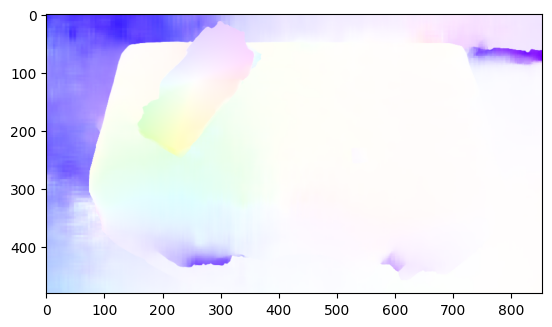

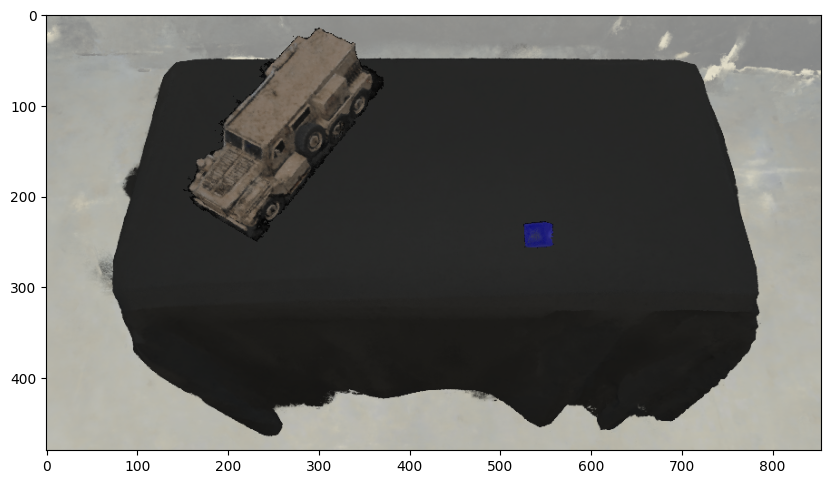

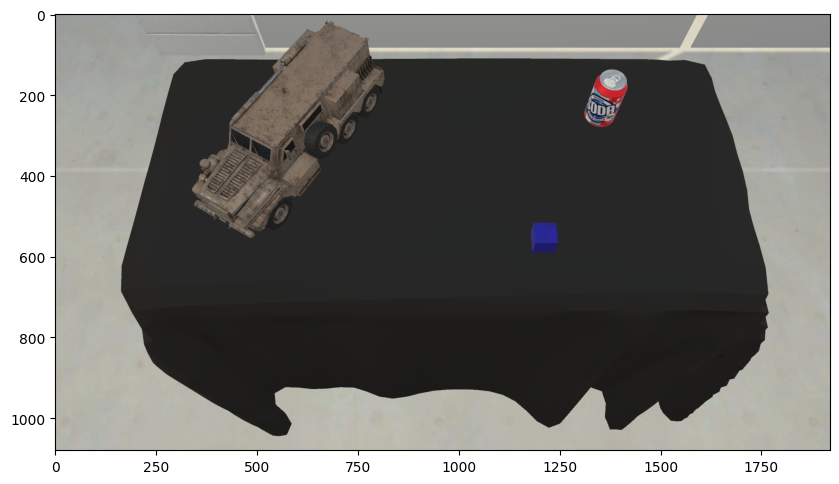

In [22]:
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

_, _, _, image_composed, _ = network()
plt.figure(figsize=(10,6))
plt.imshow(image_composed)
plt.figure(figsize=(10,6))
plt.imshow(left/255)

In [ ]:
for obj in ['truck', 'block']: 
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)
